In [1]:
%matplotlib inline
import json
import numpy as np
import plotly.graph_objects as go
import cv2
from plotly.subplots import make_subplots
from IPython.display import Image
import sys
import os
sys.path.insert(0, '../../')
from data_loader import get_data_to_load, get_counterpart

# Load data first

multiplayer_countries_map = json.load(open('../02_listing/countries_map', encoding='utf8'))
singleplayer_pre_mapping_countries_map = json.load(open('../03_mapping/pre_mapping_countries_map', encoding='utf8'))
basenames_to_country_map = json.load(open('../03_mapping/pre_mapping_basenames_to_countries_map', encoding='utf8'))
variance_map = json.load(open('../04_data_cleaning/variance_map', encoding='utf8'))

list_files = get_data_to_load(loading_file='../04_data_cleaning/updated_data_list', file_location='../01_enriching/.data/', image_file_location='../../1_data_collection/.data/', allow_new_file_creation=False, from_remote_only=True, download_link='env', allow_file_location_env=True, allow_image_file_location_env=True, allow_json_file_location_env=True, limit=25, shuffle_seed=43)
list_basenames = [os.path.basename(x) for x in list_files]
list_basenames_set = set(list_basenames)
basenames_to_file_map = {x: y for x, y in zip(list_basenames, list_files)}

# filter only .png files from the list
images_to_country_map = {get_counterpart(k): v for k, v in basenames_to_country_map.items() if k in list_basenames_set}

# Combine image_to_country_map and variance_map (they have the same keys, but different kinds of values)
# into a single dictionary, where the values are tuples of the form (country, variance)
image_to_country_variance_map = {}
for key in images_to_country_map:
    image_to_country_variance_map[key] = (images_to_country_map[key], variance_map[key])
    
# Combine the two countries maps into a single dictionary, where the values are tuples of the form (multiplayer_country, singleplayer_country)
countries_map = {}
for key in set([*multiplayer_countries_map.keys(), *singleplayer_pre_mapping_countries_map.keys()]):
    countries_map[key] = (multiplayer_countries_map.get(key, np.nan), singleplayer_pre_mapping_countries_map.get(key, np.nan))
    
# Print number of singleplayer games and number of multiplayer games by summing all the values in the countries_map
singleplayer_games = sum(singleplayer_pre_mapping_countries_map.values())
multiplayer_games = sum(multiplayer_countries_map.values())

# Display in a fancy plotly plot (not a table but a bar chart with nice big labels of the final values
fig = go.Figure(data=[
    go.Bar(name='Singleplayer', x=['Singleplayer'], y=[singleplayer_games], text=[singleplayer_games], textposition='auto'),
    go.Bar(name='Multiplayer', x=['Multiplayer'], y=[multiplayer_games], text=[multiplayer_games], textposition='auto')
])

# Display the plot
fig.show()

All local files: 403361
Filtering out unpaired files
Filtered out 17666 unpaired files
Relevant files: 257130
Limited files: 50


In [2]:
# Display the multiplayer games by country
fig = go.Figure(data=[
    go.Bar(name='Multiplayer', x=[key for key in multiplayer_countries_map], y=[multiplayer_countries_map[key] for key in multiplayer_countries_map])
])
fig.show()

In [3]:
# Display the singleplayer games by country
fig = go.Figure(data=[
    go.Bar(name='Singleplayer', x=[key for key in singleplayer_pre_mapping_countries_map], y=[singleplayer_pre_mapping_countries_map[key] for key in singleplayer_pre_mapping_countries_map])
])
fig.show()

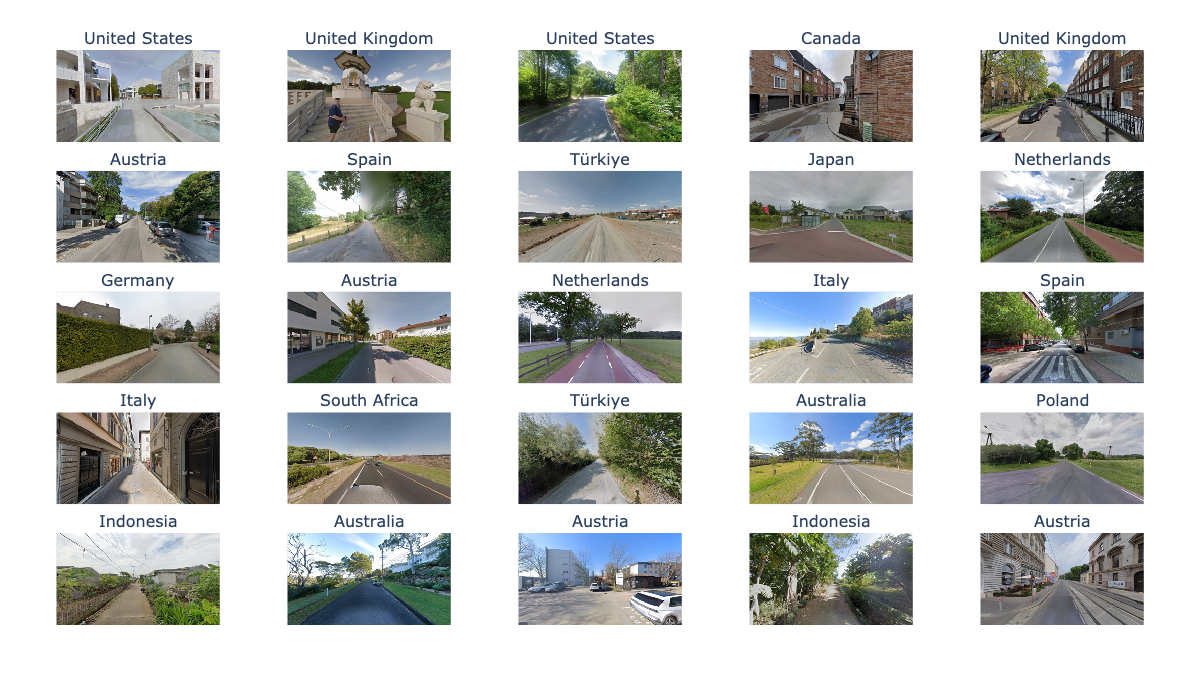

In [6]:
# Assuming image_to_country_variance_map is a dictionary with image paths and (country, variance) as values
# Initialize subplots

rows=5
cols=5

limited_items_length = min(rows * cols, len(image_to_country_variance_map))
limited_items = list(image_to_country_variance_map.items())[:limited_items_length]
limited_values = [value for value in image_to_country_variance_map.values()][:limited_items_length]

fig = make_subplots(rows=rows, cols=cols, subplot_titles=[value[0] for value in limited_values], horizontal_spacing=0.05, vertical_spacing=0.05)

# Iterate over each image and its associated data
for idx, (image_path, (country, variance)) in enumerate(limited_items):
  # Load and process the image
  image = cv2.imread(basenames_to_file_map[image_path])
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Calculate position in the grid
  row = idx // rows + 1
  col = idx % cols + 1
  
  if row > rows or col > cols:
    break

  # Add the image to the subplot
  fig.add_trace(
    go.Image(z=image_rgb),
    row=row, col=col
  )

# Update layout settings to maintain 16:9 aspect ratio for each subplot
fig.update_layout(
  width=1200,
  height=675,  # This maintains an aspect ratio of 16:9 for the entire figure
  margin=dict(l=50, r=50, t=50, b=50),  # Reduce the margins to increase image size
  showlegend=False
)

# Hide axis lines and ticks for each subplot
fig.update_xaxes(showline=False, showticklabels=False, zeroline=False)
fig.update_yaxes(showline=False, showticklabels=False, zeroline=False)

# Show the figure
fig.write_image("sample.png")

# Delete all plotly image vars to save disk space
del fig

# Load the image and display it
Image(filename='sample.png') 

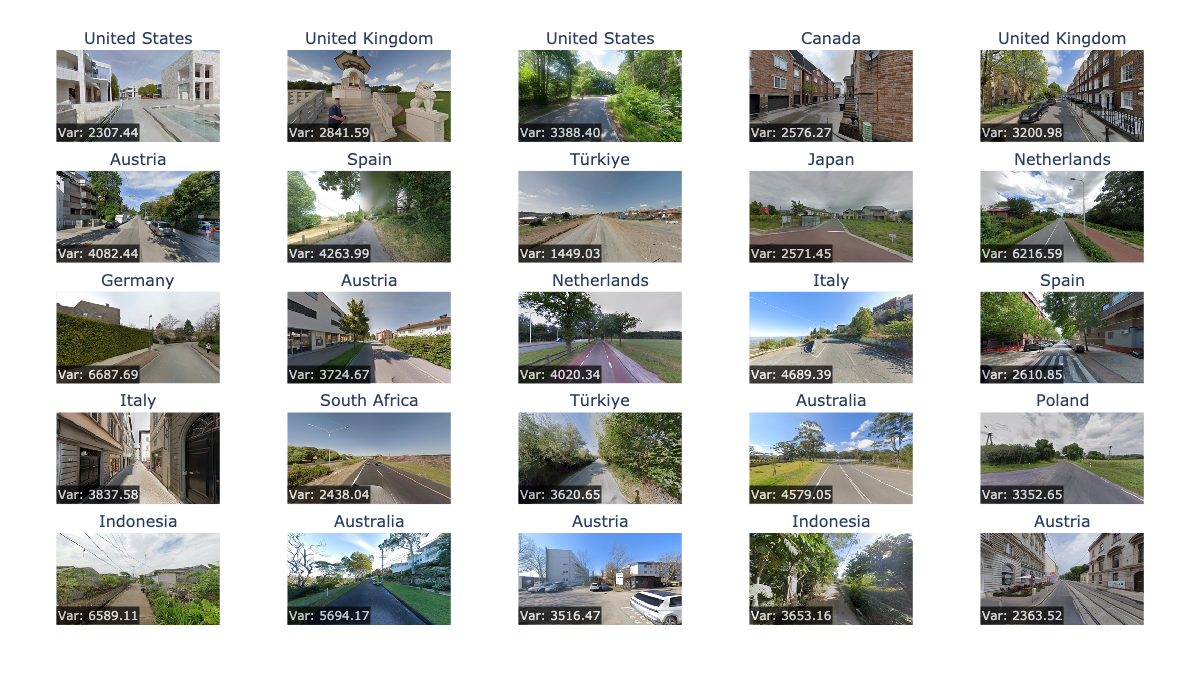

In [7]:
# Assuming image_to_country_variance_map is a dictionary with image paths and (country, variance) as values
# Initialize subplots
fig = make_subplots(rows=rows, cols=cols, subplot_titles=[value[0] for value in limited_values], horizontal_spacing=0.05, vertical_spacing=0.05)

# Iterate over each image and its associated data
for idx, (image_path, (country, variance)) in enumerate(limited_items):
  # Load and process the image
  image = cv2.imread(basenames_to_file_map[image_path])
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Calculate position in the grid
  row = idx // rows + 1
  col = idx % cols + 1
  
  if row > rows or col > cols:
    break

  # Add the image to the subplot
  fig.add_trace(
    go.Image(z=image_rgb),
    row=row, col=col
  )
    
  # Adjust annotation for variance within the domain of the subplot
  fig.add_annotation(
    text=f"Var: {variance:.2f}",  # Displaying variance as a floating point number with 2 decimal places
    x=(col - 1) / cols * 1.05 + 0.005,  # Position annotation within the subplot column on the figure canvas
    y=(rows - row) / rows * 1.05,  # Position annotation within the subplot row on the figure canvas
    xref="paper",
    yref="paper",
    xanchor="left",
    yanchor="bottom",
    showarrow=False,
    font=dict(color="white", size=12),
    bgcolor="black",
    opacity=0.7
  )

# Update layout settings to maintain 16:9 aspect ratio for each subplot
fig.update_layout(
  width=1200,
  height=675,  # This maintains an aspect ratio of 16:9 for the entire figure
  margin=dict(l=50, r=50, t=50, b=50),  # Reduce the margins to increase image size
  showlegend=False
)

# Hide axis lines and ticks for each subplot
fig.update_xaxes(showline=False, showticklabels=False, zeroline=False)
fig.update_yaxes(showline=False, showticklabels=False, zeroline=False)

# Show the figure
fig.write_image("variance.png")

# Delete all plotly image vars to save disk space
del fig

# Load the image and display it
Image(filename='variance.png') 